In [ ]:
#initialize random number Generator
import matplotlib.pyplot as plt
import numpy as np
from math import exp
import random
#initialize random number gernerator
np.random.seed(42)

# **Creating Calss Neuron**

In [ ]:
class Neuron:
    def __init__(self, num_inputs, activation_function):
        # Initialize weights and store them
        self.bias = np.random.uniform(-2.0, 2.0)  # Bias term initialized randomly between -2.0 and 2.0
        self.weights = [np.random.uniform(-2.0, 2.0) for _ in range(num_inputs)]  # Weights initialized randomly for each input
        self.activation_function = activation_function  # Activation function as a string (e.g., 'logist', 'tanh', 'id')

        # Variables needed for training the network
        # Δw = n * delta * out
        # delta = (y' - y) * f'(net) for output layer
        # delta = (∑ delta * w) * f'(net) for hidden layers
        self.delta = 0  # Error signal for backpropagation
        self.weighted_sum = 0  # Net input to the neuron
        self.out = 0  # Output of the neuron after activation
        self.out_deriv = 0  # Derivative of the output (used in backpropagation)

    def activate(self, inputs):
        # Calculate the weighted sum of the input vector plus the bias term
        self.weighted_sum = sum([w * x for (w, x) in zip(self.weights, inputs)]) + self.bias

        # Apply the activation function and return the output value
        if self.activation_function == "logist":
            # Logistic (sigmoid) function: 1 / (1 + e^(-weighted_sum))
            self.out = 1 / (1 + exp(-self.weighted_sum))
            return self.out
        elif self.activation_function == "tanh":
            # Tanh function: (e^x - e^(-x)) / (e^x + e^(-x))
            self.out = (exp(self.weighted_sum) - exp(-self.weighted_sum)) / (exp(self.weighted_sum) + exp(-self.weighted_sum))
            return self.out
        elif self.activation_function == "id":
            # Identity function: returns the weighted sum as is
            self.out = self.weighted_sum
            return self.out
        else:
            # Raise an error if an unknown activation function is provided
            raise ValueError("Unknown activation function")


# **Creating Class Layer**



In [ ]:
class Layer:
    def __init__(self, num_neurons, num_inputs, activation_function):
        # Raise an error if the number of neurons in a layer is not valid
        if num_neurons > 1000 or num_neurons < 1:
            raise ValueError("Number of neurons should be between 1 and 1000")
        # Initialize neurons in the layer and store them in a list
        self.neurons = [Neuron(num_inputs, activation_function) for _ in range(num_neurons)]

    def feed_forward(self, inputs):
        # Pass inputs through each neuron and return their outputs
        return [neuron.activate(inputs) for neuron in self.neurons]

# **Creating Class MLP**


In [ ]:
class MLP:
    def __init__(self, num_neurons, num_inputs, activation_functions):
        # Check if the length of activation_functions matches the number of layers
        if len(num_neurons) != len(activation_functions):
            raise ValueError("The number of activation functions must match the number of layers.")

        # Initialize the number of inputs for each layer
        num_inputs_per_layer = [num_inputs] + num_neurons[:-1]

        # Initialize each layer with the corresponding number of neurons, inputs, and activation function
        self.layers = [Layer(num_neurons, num_inputs, activation_function)
                       for num_neurons, num_inputs, activation_function in zip(num_neurons, num_inputs_per_layer, activation_functions)]

    def predict(self, vec):
        # Forward pass through each layer until the output layer
        x = vec  # Initialize input vector
        for layer in self.layers:
            x = layer.feed_forward(x)  # Pass output from one layer to the next
        return x  # Return final output from the last layer



# **Backpropagation Of Error**

In [ ]:
# Implement Backpropagation of Error Algorithm

def backpropagation_step(mlp, vec, learning_rate_of_each_layer):
    # Forward pass to get the prediction
    y = mlp.predict(vec[0])

    # Calculate deltas in the output layer
    for i in range(len(mlp.layers[-1].neurons)):
        neuron = mlp.layers[-1].neurons[i]

        # Calculate derivative of activation function for the output neuron
        if neuron.activation_function == "logist":
            f_net_deriv = neuron.out * (1 - neuron.out)  # Derivative of sigmoid function
        elif neuron.activation_function == "tanh":
            f_net_deriv = 1 - neuron.out ** 2  # Derivative of tanh function
        else:
            f_net_deriv = 1

        # Calculate delta for the output neuron
        neuron.delta = (vec[1][i] - y[i]) * f_net_deriv

        # Update weights and bias for the output neuron
        for w in range(len(neuron.weights)):
            neuron.weights[w] += learning_rate_of_each_layer[-1] * neuron.delta * mlp.layers[-2].neurons[w].out
        neuron.bias += learning_rate_of_each_layer[-1] * neuron.delta

    # Calculate deltas for hidden layers
    for i in range(len(mlp.layers) - 2, 0, -1):
        for index, neuron in enumerate(mlp.layers[i - 1].neurons):
            # Calculate derivative of activation function for the hidden neuron
            if neuron.activation_function == "logist":
                f_net_deriv = neuron.out * (1 - neuron.out)  # Derivative of sigmoid function
            elif neuron.activation_function == "tanh":
                f_net_deriv = 1 - neuron.out ** 2  # Derivative of tanh function
            else:
                f_net_deriv = 1

            # Calculate delta for the hidden neuron
            neuron.delta = sum(
                [next_neuron.delta * next_neuron.weights[index] for next_neuron in mlp.layers[i + 1].neurons]
            ) * f_net_deriv

            # Update weights and bias for the hidden neuron
            for w in range(len(neuron.weights)):
                neuron.weights[w] += learning_rate_of_each_layer[i] * neuron.delta * mlp.layers[i - 1].neurons[w].out
            neuron.bias += learning_rate_of_each_layer[i] * neuron.delta

    # Update the first layer
    for index, neuron in enumerate(mlp.layers[0].neurons):
        # Calculate derivative of activation function for the first layer neuron
        if neuron.activation_function == "logist":
            f_net_deriv = neuron.out * (1 - neuron.out)  # Derivative of sigmoid function
        elif neuron.activation_function == "tanh":
            f_net_deriv = 1 - neuron.out ** 2  # Derivative of tanh function
        else:
            f_net_deriv = 1

        # Calculate delta for the first layer neuron
        neuron.delta = sum(
            [next_neuron.delta * next_neuron.weights[index] for next_neuron in mlp.layers[1].neurons]
        ) * f_net_deriv

        # Update weights and bias for the first layer neuron
        for w in range(len(neuron.weights)):
            neuron.weights[w] += learning_rate_of_each_layer[0] * neuron.delta * vec[0][w]
        neuron.bias += learning_rate_of_each_layer[0] * neuron.delta





# Training function
def backpropagation(mlp, number_of_iterations, train_data, learning_rate_of_each_layer):
    error_list = []

    # Iterate through the number of training iterations
    for iteration in range(number_of_iterations):
        total_error = 0

        # Iterate over each training data point
        for data in train_data:
            # Perform a backpropagation step for the given data
            backpropagation_step(mlp, [data[:-1], [data[-1]]], learning_rate_of_each_layer)

            # Calculate the error for the prediction
            predicted_output = mlp.predict(data[:-1])
            total_error += sum([(predicted_output[i] - data[-1]) ** 2 for i in range(len(predicted_output))])

        # Append the average error for this iteration
        error_list.append(total_error / len(train_data))

        # Print the error for each iteration (optional, for debugging)
        # print(f"Iteration {iteration + 1}, Error: {total_error / len(train_data)}")

    # Save learning curve to file
    with open("learning_curve.txt", "w") as f:
        for i, error in enumerate(error_list):
            f.write(f"{i + 1} {error}\n")

    # Visualize the learning curve
    plt.plot(range(1, number_of_iterations + 1), error_list)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.title('Learning Curve')
    plt.show()


# **Data Pre-processing**



In [ ]:
# Initialize an empty list to hold the 2D list structure
training_data = []

# Open the file and read it line by line
with open('/content/sample_data/PA-A_training_data_04.txt') as file:
    for line in file:
        # Split each line by whitespace and convert it to a list of values
        values = line.split()
        # Append the parsed values to the main list
        training_data.append(values)

# Skip the first four rows (assuming these are header rows)
training_data = training_data[4:]

# Convert all elements to float
for i in range(len(training_data)):
    for j in range(len(training_data[i])):
        training_data[i][j] = float(training_data[i][j])

# Print the processed training data
print(training_data)

# Split the data into training and test sets
# Set the desired split ratio (80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(training_data) * split_ratio)

# Shuffle the data to ensure randomness
random.shuffle(training_data)

# Split the data into training and testing sets
train_data = training_data[:split_index]
test_data = training_data[split_index:]

# Separate features and labels for the training set
train = []
for data in train_data:
    train.append(data[:-1])  # Append features (all except the last element)
    train.append([data[-1]])  # Append label (last element)

# Separate features and labels for the test set
test = []
for data in test_data:
    test.append(data[:-1])  # Append features (all except the last element)
    test.append([data[-1]])  # Append label (last element)


[[-1.91919, -1.0, 0.550063], [-1.87879, -1.0, 0.552135], [-1.47475, -1.0, 0.469293], [-1.43434, -1.0, 0.451852], [-1.39394, -1.0, 0.433109], [-1.15152, -1.0, 0.300662], [-1.11111, -1.0, 0.276604], [-1.07071, -1.0, 0.252388], [-1.0303, -1.0, 0.228172], [-0.989899, -1.0, 0.204114], [-0.949495, -1.0, 0.180372], [-0.909091, -1.0, 0.157101], [-0.666667, -1.0, 0.0355155], [-0.10101, -1.0, -0.0273895], [-0.0606061, -1.0, -0.0177471], [-0.020202, -1.0, -0.00634131], [0.020202, -1.0, 0.00675336], [0.0606061, -1.0, 0.0214515], [0.10101, -1.0, 0.0376572], [0.141414, -1.0, 0.0552646], [0.181818, -1.0, 0.0741589], [0.222222, -1.0, 0.0942167], [0.262626, -1.0, 0.115307], [0.30303, -1.0, 0.137293], [0.343434, -1.0, 0.16003], [0.666667, -1.0, 0.3506], [0.707071, -1.0, 0.373163], [0.747475, -1.0, 0.394937], [0.787879, -1.0, 0.415782], [0.828283, -1.0, 0.435561], [0.868687, -1.0, 0.454145], [0.909091, -1.0, 0.471413], [0.949495, -1.0, 0.487251], [0.989899, -1.0, 0.501557], [1.0303, -1.0, 0.514237], [1.0

# **MLP Example**

In [ ]:
# Example MLP configuration
num_neurons = [2,3,3,1]  # Number of neurons in each layer
num_inputs = 2  # Number of inputs to the first layer
activation_functions = [ "tanh","tanh","tanh","tanh"]  # Activation functions for each layer

mlp = MLP(num_neurons, num_inputs, activation_functions)



#**Test the code**

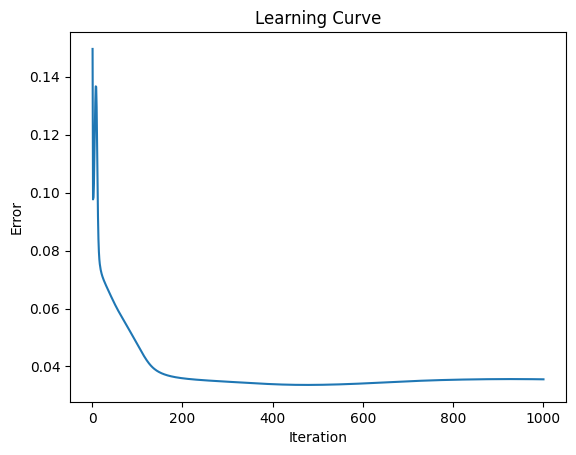

In [ ]:
backpropagation(mlp,1000,train_data,[0.01,0.01,0.01,0.01])

In [ ]:
def test_mlp(mlp, test_data):
    total_error = 0
    correct_predictions = 0
    predictions = []

    # Iterate over each test data point
    for data in test_data:
        # Perform a forward pass to get the prediction
        predicted_output = mlp.predict(data[:-1])
        predictions.append(predicted_output)

        # Calculate the error for the prediction
        error = sum([(predicted_output[i] - data[-1]) ** 2 for i in range(len(predicted_output))])
        total_error += error

    # Calculate average error across all test samples
    avg_error = total_error / len(test_data)

    # Print the results
    print(f"Average Error on Test Set: {avg_error}")

    # Return predictions and average error
    return predictions, avg_error


# Run the test function on the test data
predictions, avg_error = test_mlp(mlp, test_data)

# Print predictions for analysis


Average Error on Test Set: 0.04216846730675933
